Directory cleared. Current contents: ['.config', 'sample_data']


Saving anomaly_detection.py to anomaly_detection.py
Saving theft_protection.zip to theft_protection.zip
Saving utils.py to utils.py
Contents of theft_protection.zip:
['single_thread/.DS_Store', 'single_thread/version description.rtf', 'single_thread/version_1.1/', 'single_thread/version_1.1/.DS_Store', 'single_thread/version_1.1/normal/', 'single_thread/version_1.1/normal/log1', 'single_thread/version_1.1/normal/log2', 'single_thread/version_1.1/normal/log3', 'single_thread/version_1.1/normal/log4', 'single_thread/version_1.1/normal/log5', 'single_thread/version_1.1/normal/log6', 'single_thread/version_1.1/normal/trace1', 'single_thread/version_1.1/normal/trace2', 'single_thread/version_1.1/normal/trace3', 'single_thread/version_1.1/normal/trace4', 'single_thread/version_1.1/normal/trace5', 'single_thread/version_1.1/normal/trace6', 'single_thread/version_1.1/semantic_error/', 'single_thread/version_1.1/semantic_error/log1', 'single_thread/version_1.1/semantic_error/log2', 'single_thre

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 2.2117 - mae: 0.6506 - val_loss: 1.4251 - val_mae: 0.5225
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 1.2147 - mae: 0.5076 - val_loss: 0.9680 - val_mae: 0.4810
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.9519 - mae: 0.5260 - val_loss: 0.7560 - val_mae: 0.4549
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.7210 - mae: 0.4728 - val_loss: 0.5889 - val_mae: 0.3906
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.5565 - mae: 0.4305 - val_loss: 0.3756 - val_mae: 0.3141
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.3506 - mae: 0.3459 - val_loss: 0.2962 - val_mae: 0.2932
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.3682 - mae: 0.3467 - val_loss: 0.2671 - val_mae: 0.2769
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.3201 - mae: 0.3330 - val_loss: 0.2175 - val_mae: 0.2517
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/s

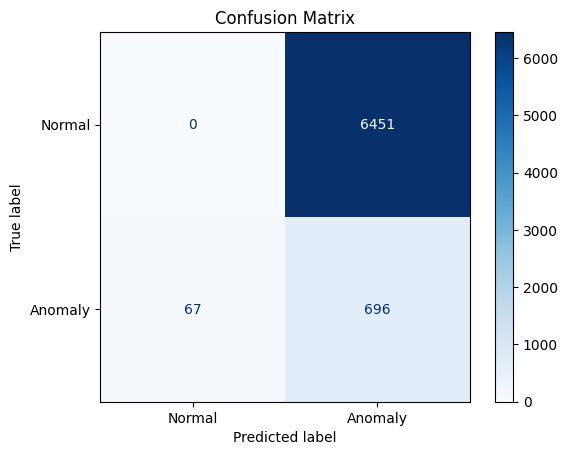

In [1]:
import os
import numpy as np
import pandas as pd
import json
import shutil
from sklearn.preprocessing import MinMaxScaler,StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import zipfile
from google.colab import files
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import psutil
import time

def get_ram_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)



# Clean the directory
current_dir = './'
for item in os.listdir(current_dir):
    if item not in ['.config', 'sample_data']:
        item_path = os.path.join(current_dir, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

print("Directory cleared. Current contents:", os.listdir(current_dir))

# Upload files
uploaded = files.upload()

# Extract and organize data
zip_file_path = './theft_protection.zip'
extraction_path = './theft_protection'
base_dir = './trace_data'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Contents of theft_protection.zip:")
        print(zip_ref.namelist())
        zip_ref.extractall(extraction_path)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    if os.path.exists('./theft_protection'):
        shutil.move('./theft_protection', f'{base_dir}/theft_protection')
else:
    print("Zip file not found.")

from utils import get_paths, read_traces, read_json, mapint2var, is_consistent
from anomaly_detection import test_single, merge_detections, get_correct_detections

# Configuration
CODE = 'theft_protection'
BEHAVIOUR_FAULTY = 'faulty_data'
BEHAVIOUR_NORMAL = 'normal'
THREAD = 'single'
VER = 3

base_dir = './trace_data'
normalbase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = [os.path.join(normalbase_path, x) for x in os.listdir(normalbase_path) if 'varlist' in x]

paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

train_data = np.concatenate([read_traces(file) for file in train_data_path])
scaler = RobustScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Prepare GRU training data
sequence_length = 60
X_train, y_train = [], []
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i + sequence_length])
    y_train.append(train_data_scaled[i + sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define GRU model
model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(sequence_length, train_data_scaled.shape[1]), kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    GRU(64, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(X_train.shape[2], activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)
training_time = time.time() - start_time



# Test data
test_data = np.concatenate([read_traces(file) for file in paths_traces])
test_data_scaled = scaler.transform(test_data)
X_test, y_test = [], []
for i in range(len(test_data_scaled) - sequence_length):
    X_test.append(test_data_scaled[i:i + sequence_length])
    y_test.append(test_data_scaled[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

# Predictions and errors
predictions = model.predict(X_test)
errors = np.mean(np.abs(predictions - y_test), axis=1)
train_predictions = model.predict(X_train)
train_errors = np.mean(np.abs(train_predictions - y_train), axis=1)

# Finding anomalies by using threshold
threshold = np.percentile(train_errors, 95)
anomalies = errors > threshold

y_pred_all = []
y_true_all = []
all_detections = []
all_tp, all_fp, all_fn, all_gt = [], [], [], []
DIFF_VAL = 0

for test_data_path, test_label_path in zip(paths_traces, paths_label):
    detection = test_single(test_data_path, model, scaler, sequence_length, threshold)
    merged_detection, _ = merge_detections(detection, DIFF_VAL)

    ground_truth_raw = read_traces(test_label_path)
    ground_truth = ground_truth_raw['labels'][list(ground_truth_raw['labels'].keys())[0]]

    correct_pred, rest_pred, y_pred, y_true, false_neg = get_correct_detections(merged_detection, ground_truth)
    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)
    all_tp.append((test_data_path, correct_pred, test_label_path))
    all_fp.append((test_data_path, rest_pred, test_label_path))
    all_fn.append((test_data_path, false_neg, test_label_path))
    all_gt.append((test_data_path, ground_truth, test_label_path))

y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)

# Calculate evaluation metrics
precision = precision_score(y_true_all, y_pred_all)
recall = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
ram_usage = get_ram_usage()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"training time: {training_time:.4f} seconds")
print(f"RAM usage: {ram_usage:.2f} MB")

conf_matrix = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

